In [1]:
import rasterio
import os, time, datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, set_link_color_palette
from dtw import *

from preprocess import data_extractor, resize_ndvi 
from utilefunc.get_band_order_GS2 import get_band_order_GS2
from utilefunc.resample import resample
from utilefunc.get_palette import get_palette
from evolution_graph import evolution_graph_to_synopsis

np.set_printoptions(threshold=30)
#%matplotlib widget
%matplotlib inline

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# DATA Import

In [2]:
## segmentation parameters 
scale=5        # controls the number of produced segments as well as their size. Higher scale means less and larger segments. 
sigma=0          # diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
min_size=5      # minimum size of the segment

## BB selection and graph construction parameters
alpha = 0.4
t1 = 0.1
t2 = 0
direction=1  # 0 : from small to big; 1: from big to small

In [3]:
## general data informations
fields_data_fpath = 'pinnote_anomaly_info/annotations_valid_dates_final.csv'
fields_data = pd.read_csv(fields_data_fpath, sep=';', )   # a list of season field ids
sfd_ids = fields_data['sfd_id'].unique()  # all season field ids to process
data_path = 'data_images_2017_2020/'  # path for image time series, each stocked in a file folder named with the sfd_id

# save paths
save_path_df = 'variables/raster_df/scale_{0}/'.format(scale)
if direction == 0:
    save_path_bb = 'variables/BB_evolution_graph/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables/sfd_bbs_cover/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
if direction == 1:
    save_path_bb = 'variables/BB_evolution_graph/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables/sfd_bbs_cover/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)

# Save paths for Evolution processes
savePath = 'ImageResults'

In [4]:
fields_data = pd.read_csv(fields_data_fpath, sep=';')  # a file of season field ids with year
sfd_ids = fields_data['sfd_id'].unique()  # all season field ids to process 

In [5]:
# Take 1 seasonal fields 
sfd_ids = np.array([102112829]) # sfd_ids
sfd_ids

array([102112829])

# Load and Display the Input

In [6]:
def normalize(array):
    arrayMin, arrayMax = array.min(), array.max()
    return ((array-arrayMin)/(arrayMax-arrayMin))


In [7]:
#####################################################################################
# Process each field to get BBs and evolution graphs
# year_choice = 2020 # if we process all fields of a specific year (or a liste of years) and we comment line 62
for sfd_id_choice in sfd_ids:
    # ---------- Step 1 : Data acquisition
    # get image file names of the season field id
    
    year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0] # different year for different fields
    band_gil_file, band_tif_file, ndvi_tif_file = data_extractor(data_path, sfd_id_choice, year_choice)
    #'''
    if band_gil_file.size >= 2:  # each time series need at least 2 images
        # ---------- Step 2 : Image data preprocessing
        # prepare for ndvi image resizing, the 'mask_dict' saves an unified standard image size for the time series of a field
        mask_dict, tif_info = resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice)
        
        raster_df = []
        date = []
        todelete = []
        for i in range(len(band_gil_file)):
            # for each image in the satellite image time series for the sfd_id
            if band_gil_file[i].split('_')[3] in ['Sentinel2', 'Landsat8']: # we choose only these 2 satellite capteurs
                img_band_gil = data_path + str(sfd_id_choice)+ '/' + band_gil_file[i]
                img_band_tif = data_path + str(sfd_id_choice) + '/' + band_tif_file[i]
                img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
                # Bands and NDVI images are listed by the same date order
                date.append(band_gil_file[i].split('_')[2]) 
                
                # raster band #  ['green', 'red', 'blue'])  -4,2,3
                bands_green_red_nir = get_band_order_GS2(img_band_gil, ['green', 'red', 'nir'])#4-2-1              
                raster_band = rasterio.open(img_band_tif)                
                raster_band_numpy = raster_band.read(bands_green_red_nir, masked=True) # attention masked # channel order meaning : (3, height, width)
                
                #### best way to Visualize is the NDVI
                ndvi_numpy = (raster_band_numpy[2] - raster_band_numpy[1] )/(raster_band_numpy[2] + raster_band_numpy[1])
                # the same ndvi generation
                
                # raster ndvi
                raster_ndvi = rasterio.open(img_ndvi_tif)
                raster_ndvi_numpy = raster_ndvi.read(1, masked=True) # NDVI image only one channel
                # resize the NDVI image to the standard size
                raster_ndvi_numpy = resample(raster_ndvi_numpy, mask_dict[sfd_id_choice])   
        
                # resize bands image according to the already unified NDVI image of the same date
                raster_resampled_1 = resample(raster_band_numpy[0,:,:], raster_ndvi_numpy).filled(np.nan)
                raster_resampled_2 = resample(raster_band_numpy[1,:,:], raster_ndvi_numpy).filled(np.nan)
                raster_resampled_3 = resample(raster_band_numpy[2,:,:], raster_ndvi_numpy).filled(np.nan)
                raster_band_numpy_resampled = np.stack((raster_resampled_1, raster_resampled_2, raster_resampled_3), axis=0)
                raster_band_numpy_resampled = np.ma.masked_invalid(raster_band_numpy_resampled) # channel : (3, height, width) # raster_band_numpy resampled with mask # not filled() 
       #'''

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\numpy\ma\core.py:1020: RuntimeWarning: overflow encountered in add
  result = self.f(da, db, *args, **kwargs)


In [8]:
tif_info

{'EPSG': 32614,
 'transform': Affine(10.0, 0.0, 369640.0,
        0.0, -10.0, 4259440.0)}

In [9]:
bands_green_red_nir

[4, 2, 1]

In [10]:
band_gil_file

array(['102112829_Bands_20180322_Sentinel2_Clear_151.gil',
       '102112829_Bands_20180329_Sentinel2_Clear_150.gil',
       '102112829_Bands_20180428_Sentinel2_Clear_148.gil',
       '102112829_Bands_20180530_Landsat8_Clear_147.gil',
       '102112829_Bands_20180531_Sentinel2_Clear_146.gil',
       '102112829_Bands_20180615_Sentinel2_Clear_144.gil',
       '102112829_Bands_20180627_Sentinel2_Clear_143.gil',
       '102112829_Bands_20180630_Sentinel2_Clear_142.gil',
       '102112829_Bands_20180701_Landsat8_Clear_141.gil',
       '102112829_Bands_20180717_Sentinel2_Clear_139.gil',
       '102112829_Bands_20180802_Landsat8_Clear_138.gil',
       '102112829_Bands_20180824_Sentinel2_Clear_137.gil',
       '102112829_Bands_20180826_Sentinel2_Clear_136.gil',
       '102112829_Bands_20180919_Landsat8_Clear_135.gil',
       '102112829_Bands_20180923_Sentinel2_Clear_134.gil',
       '102112829_Bands_20181021_Landsat8_Clear_133.gil',
       '102112829_Bands_20181028_Sentinel2_Clear_132.gil',
  

In [11]:
# Display the input all 
#band_tif_file #19

In [12]:
#ndvi_tif_file

In [13]:
#ndvi_numpy.shape

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


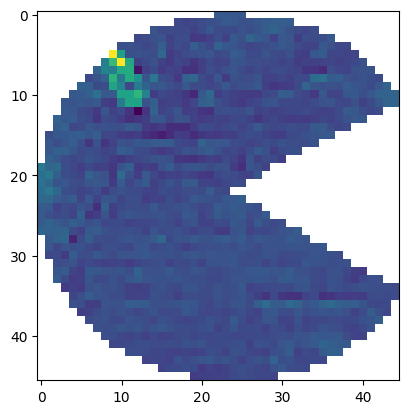

In [14]:
plt.close('all')
a = raster_band.read(1, masked=True)
b = raster_ndvi.read(1, masked=True) # NDVI image only one channel
c = raster_band.read(bands_green_red_nir, masked=True) # attention masked # channel order meaning : (3, height, width)
plt.imshow(ndvi_numpy)
plt.show()

# Feature Extraction + Evolution graph  (Load the result)

In [15]:
fld_year_synopsis = []

for sfd_id_choice in sfd_ids:
    year_choice = fields_data[fields_data.sfd_id == sfd_id_choice].year.unique()[0]
    ##### Feature Extraction
    # To have this run the file - FeatureExtraction (CD_workflow.py) or(FeatureExtraction_Check.ipynb) up to step 3:segmentation
    raster_df = pd.read_pickle(save_path_df+'{0}_{1}_scale_{2}_raster_seg_df.pkl'.format(sfd_id_choice,year_choice,scale))
    
    dico_year_synopsis = {}
    dico_year_num_bb = {}
    
    segments_test = raster_df['segments_fz'].iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]
    raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy'].iloc[(raster_df.index >= datetime.datetime(year_choice,1,1)) & (raster_df.index <= datetime.datetime(year_choice,12,31))]
    
    # To have this run the file - FeatureExtraction (CD_workflow.py) or(FeatureExtraction_Check.ipynb) step 4-> 5 :Evolution graph
    bb_final_list = np.load(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), allow_pickle=True)

    #### Evolution graph of each BB given the (fld_id, year) --> yield the synopsis from evolotion graph
    #### The output is the NDVI mean weight of each bounding box 
    #### Ex we have 16 bounding box --> 16 synopses of 19 images (synopses graph)
    dico_year_synopsis[year_choice] = evolution_graph_to_synopsis(sfd_id_choice, year_choice, bb_final_list, segments_test, raster_ndvi_numpy_test, alpha, t1, t2)

    fld_year_synopsis.append(dico_year_synopsis)
    
fld_year_synopsis_df = pd.DataFrame(fld_year_synopsis, index=sfd_ids)
fld_year_synopsis_df

,2018
102112829,"[([2018-03-22 00:00:00, 2018-03-29 00:00:00, 2..."


# Clustering (unsupervised learning method)

In [16]:
year_choice = 2018
crop_type = 'Corn'
all_dates = []
n_synopsis = 0
for sfd_id_choice in sfd_ids:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
        # Take out the day frOm the Timestamp
        all_dates+=[t.dayofyear for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice] for t in x[0]]
        # The N-of synopsis 
        n_synopsis += len(fld_year_synopsis_df.loc[sfd_id_choice][year_choice])

uni_dates = np.unique(all_dates) # used dates of all synopsis of all fields
n_synopsis

16

In [17]:
### Prepare the data_uniform data for clustering (linkage -Agglorerative Hierarchical method)
all_synopsis_list = []
all_date_list = []
data_uniform_array = np.ones((n_synopsis, len(uni_dates)))*1000 #16x19

update = 0
syn_label = []

for sfd_id_choice in sfd_ids:
    if type(fld_year_synopsis_df.loc[sfd_id_choice][year_choice]) != type(np.nan) and fields_data[fields_data.sfd_id == sfd_id_choice].croptype.values[0] == crop_type:
        date_list = []
        synopsis_list = []
        bb_ids = []
        # Extracting the information into the date_list/ synopsis_list/ bb_ids
        for x in fld_year_synopsis_df.loc[sfd_id_choice][year_choice]:
            date_list.append(x[0])
            synopsis_list.append(x[1])
            bb_ids.append(str(x[2][0]) + '_' + str(x[2][1]))
        helper = pd.DataFrame({'date':[pd.to_datetime(uni_dates[i]-1, unit='D', origin=str(year_choice)) for i in range(len(uni_dates))]}) # used dates of all synopsis of all fields
        #'''
        for i in range(len(date_list)):
            df = pd.DataFrame({'date':date_list[i], 'val':synopsis_list[i]})
            df = pd.merge(df, helper, on='date', how='outer').sort_values('date')
            # Interpolate the missing value in synopsis
            df['val'].interpolate(method='linear', limit_area='inside', inplace=True) 
            #df.interpolate(method='linear', limit_area='inside', inplace=True)
            # Transform into array the synopsis values - shape (16,19)
            data_uniform_array[update] = df['val'].values
            update += 1
        
            syn_label.append(str(sfd_id_choice)+':'+bb_ids[i])
        #'''    
        all_date_list += date_list # Form the storage to keep all information of images
        all_synopsis_list += synopsis_list # Form the storage to keep all information of images 

# Return the np.nan         
data_uniform_array[data_uniform_array==1000] = np.nan
#print(f'n_synopsis size : {n_synopsis}')

clustered_sfd_ids = list(set([el.split(':')[0] for el in syn_label]))
data_uniform_array # NVDI Net weight of 16 bounding box coresponding to 19 images -> shape (16,19)

array([[0.18322263, 0.17666912, 0.16366464, ..., 0.20151739, 0.19972172,
        0.18018614],
       [0.1838882 , 0.17835463, 0.16353522, ..., 0.20056044, 0.20043148,
        0.17981298],
       [0.18903973, 0.18474894, 0.1744279 , ..., 0.19834764, 0.19813738,
        0.17448521],
       ...,
       [0.19119499, 0.19061044, 0.18245133, ..., 0.20503568, 0.19313703,
        0.1743561 ],
       [0.21128702, 0.20987262, 0.22305004, ..., 0.2674661 , 0.24041223,
        0.23952838],
       [0.20956153, 0.25237384, 0.3179228 , ..., 0.23682192, 0.21598651,
        0.19931723]])

In [18]:
# Aggolerative Hierarchical Clustering 
def dtw_normalized_dist(a, b):
    # find dates where both of the two time series have data
    common = ~np.isnan(a) & ~np.isnan(b)
    a_c = a[common]
    b_c = b[common]
    if a_c.size == 0 or b_c.size == 0: # if one of them is empty, it means they have non dates in common
        distance = 1   #10
    else:
        # delete NANs in the beginning and the end of the time series
        a = a[~np.isnan(a)]
        b = b[~np.isnan(b)]
        alignment = dtw(a, b, keep_internals=True)
        distance = alignment.normalizedDistance  # normalised by the sum of lengths of the two series
    return distance

method = 'average'
# input 16x19 --> out 15x4 (N-1)x4 - 15 iteration for clustering
'''
 At the i-th iteration, clusters n with indices Z[i, 0] and Z[i, 1] are combined to form cluster (n+1).
 A cluster with an index less than n corresponds to one of the n original observations. 
 The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. 
 The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
'''
# Estimate the dtw distance betwwen each sysnosis and clustering
Z = linkage(data_uniform_array, method=method, metric=dtw_normalized_dist)
Z

array([[1.00000000e+00, 2.00000000e+00, 1.09738647e-02, 2.00000000e+00],
       [4.00000000e+00, 1.60000000e+01, 1.33463533e-02, 3.00000000e+00],
       [5.00000000e+00, 8.00000000e+00, 1.48909276e-02, 2.00000000e+00],
       ...,
       [2.60000000e+01, 2.70000000e+01, 3.40598851e-02, 1.40000000e+01],
       [7.00000000e+00, 2.80000000e+01, 1.25461820e-01, 1.50000000e+01],
       [1.20000000e+01, 2.90000000e+01, 1.97457229e-01, 1.60000000e+01]])

# Display the result

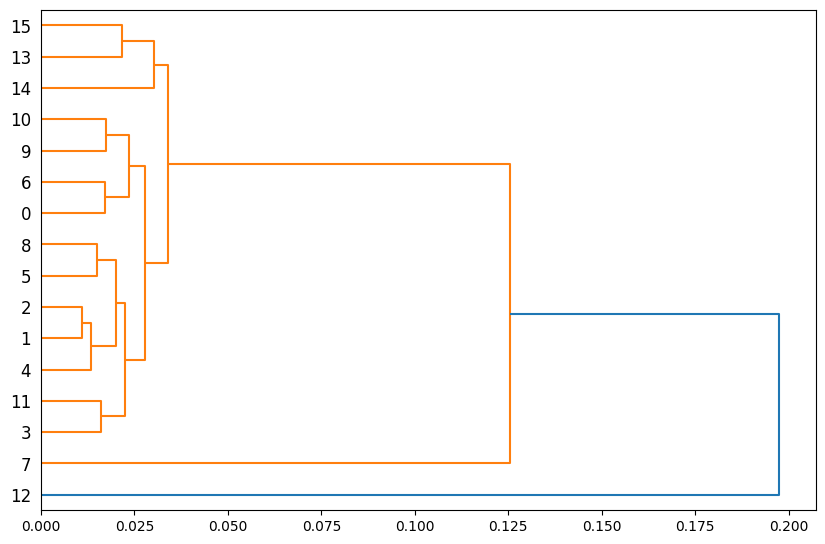

In [19]:
#### dendrogram
#threshold = 0.015
#labels = fcluster(Z, t=threshold, criterion='distance')

# set_link_color_palette(None)

plt.figure(figsize=(10, 6.5))
d = dendrogram(Z,
               orientation='right', 
              # truncate_mode='level', 
              # p=n_synopsis, 
               #color_threshold=threshold, 
             # above_threshold_color='grey',
                )

#plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
#plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : {method}, cut level at {threshold}")
plt.show()

# Threshold Optimation

In [20]:
def get_cluster_color(dendrogram):
    '''
    Return:
    The class of dendogram - This case (C0,'#ff0029')
    '''
    cluster_idxs = dict()
    for c, pi in zip(dendrogram['color_list'], dendrogram['icoord']):
        l = []
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                l.append(int(i)) # unuse
        cluster_idxs[c] = cluster_idxs.get(c, []) + l
    cluster_classes = dict()
    for c, l in cluster_idxs.items():
        i_l = [dendrogram['ivl'][i] for i in l]
        cluster_classes[c] = np.unique(i_l)
    return cluster_classes

cluster_color = get_cluster_color(d)
cluster_color.keys()
cluster_color.items()

dict_items([('C1', array(['0', '1', '10', '11', '13', '14', '15', '2', '3', '4', '5', '6',
       '7', '8', '9'], dtype='<U2')), ('C0', array(['12'], dtype='<U2'))])

In [21]:
xthreshold = np.arange(0.1,0,-0.005)

intra_std = []
intra_mean = []
inter = []
num_cluster = []
x = []
plt.figure()
for threshold in xthreshold:
    d = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, color_threshold=threshold, above_threshold_color='grey')

    cluster_color = get_cluster_color(d)
    if len(cluster_color.keys())>50:
        break
    else:
        centers = []
        # inertie intra cluster - among clusters
        intra_k = []
        for idx, (k, v) in enumerate(cluster_color.items()):
            l = [int(i) for i in v] # list the cluster same colors Ex- in grey

            if len(l) != 0:
                center = np.nanmean(data_uniform_array[l, :], axis=0)# calculate all the mean of n_sunpsis of each day
                centers.append(center) # (**,19) aaray - ** depend on the field

                inertie_intra = 0
                for j in l:
                    # Cumulative the normalized distance dtw between center and each date
                    inertie_intra += dtw_normalized_dist(data_uniform_array[j, :], center)**2 
                inertie_intra = inertie_intra/len(l) # average cummulative Normalized between center and each date
            else:
                continue
            intra_k.append(inertie_intra)
    #         print(f'inertie intra cluster : {k} - {inertie_intra}')
    
        intra_std.append(np.nanstd(intra_k))
        intra_mean.append(np.nanmean(intra_k))

        # inertie inter clusters - between clusters
        inertie_inter = 0
        c = np.nanmean(np.array(centers), axis=0)#  
        for center in centers:
            # Cummulative betwwen the Mean of ** abd 
            inertie_inter += dtw_normalized_dist(c, center)**2
            inertie_inter = inertie_inter/len(centers)
        inter.append(inertie_inter)
        num_cluster.append(len(centers))
#     print(f'inertie inter cluster : {inertie_inter}')
        x.append(threshold)
plt.close()

C:\Users\qle\AppData\Local\Temp\ipykernel_15768\2129612833.py:23: RuntimeWarning: Mean of empty slice
  center = np.nanmean(data_uniform_array[l, :], axis=0)# calculate all the mean of n_sunpsis of each day


C:\Users\qle\AppData\Local\Temp\ipykernel_15768\3263049059.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')


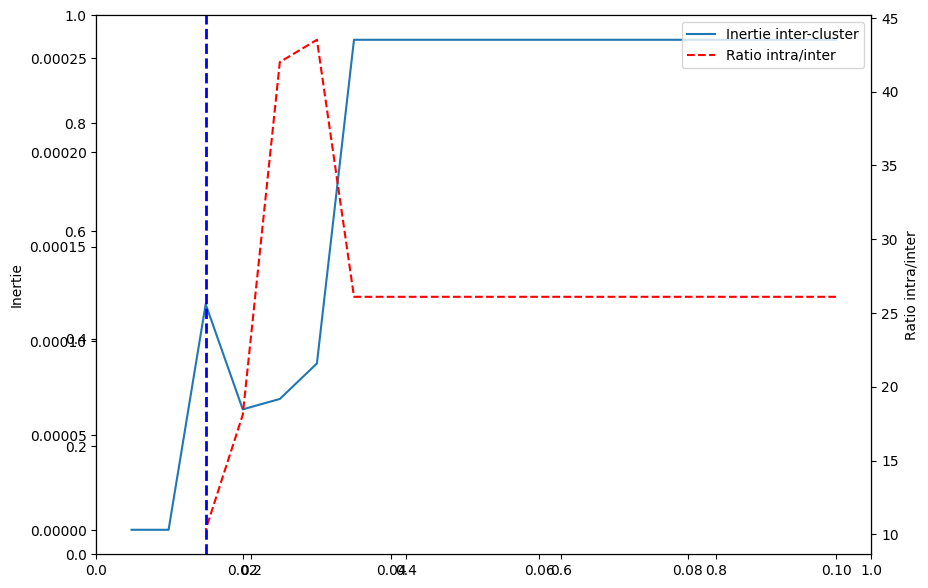

In [22]:
fig = plt.figure(figsize=(10,7))
plt.grid(True)
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
# ax2.plot(x, num_cluster, '--g', label='Nombre de clusters')
# ax2.set_ylabel('Nombre de clusters')

ax1.plot(x, inter, label='Inertie inter-cluster')
ax1.set_ylabel('Inertie')

#ax1.errorbar(x, intra_mean, yerr=intra_std, fmt='--.r', ecolor='grey', elinewidth=2, capsize=2, label='Inertie intra cluster')
#ax1.plot(x, intra_std, '--o', label='Std intra cluster')
ax2.plot(x, [intra_mean[i]/inter[i] for i in range(len(x))], '--r', label='Ratio intra/inter')
ax2.set_ylabel('Ratio intra/inter')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.axvline(x=0.015, c='b', lw=2, linestyle='dashed')
plt.show()

# Display the result with optimal parameter

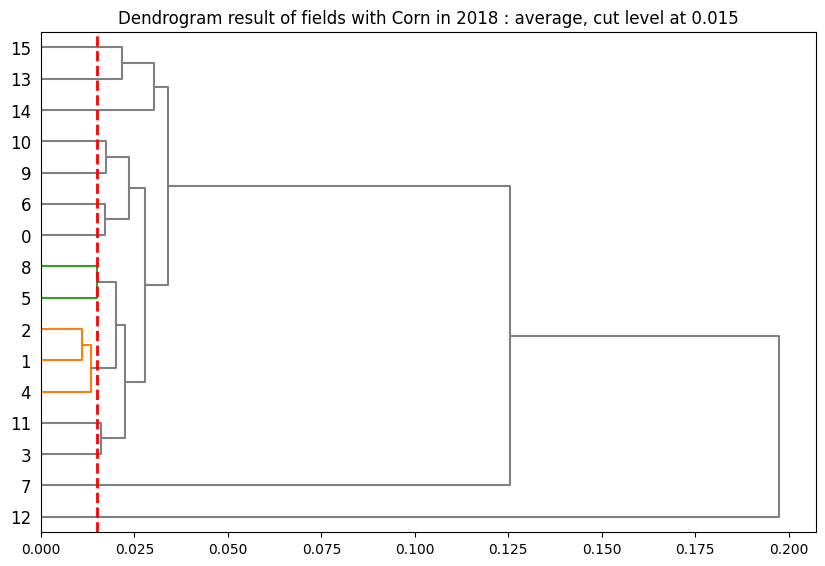

['1', '2', '4', '5', '8']

In [23]:
#### dendrogram
threshold = 0.015
labels = fcluster(Z, t=threshold, criterion='distance')

# set_link_color_palette(None)

plt.figure(figsize=(10, 6.5))
d = dendrogram(Z,
               orientation='right', 
               truncate_mode='level', 
               p=n_synopsis, 
               color_threshold=threshold, 
               above_threshold_color='grey',
                )

plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : {method}, cut level at {threshold}")
plt.show()

cluster_color = get_cluster_color(d)
label_color = {label:k for k,v in cluster_color.items() for label in v}
len(cluster_color.keys())
cluster_anomaly = {label:k for k,v in cluster_color.items() for label in v if k != 'grey'}
#cluster_anomaly = cluster_color[cluster_color != 'grey']
#print(f"The anomaly cluster are {}")
listAnomaly = list(cluster_anomaly.keys())
#cluster_anomaly
listAnomaly

In [24]:
label_color # synopsis (1-2-4)-(5-8)

{'0': 'grey',
 '10': 'grey',
 '11': 'grey',
 '12': 'grey',
 '13': 'grey',
 '14': 'grey',
 '15': 'grey',
 '3': 'grey',
 '6': 'grey',
 '7': 'grey',
 '9': 'grey',
 '1': 'C1',
 '2': 'C1',
 '4': 'C1',
 '5': 'C2',
 '8': 'C2'}

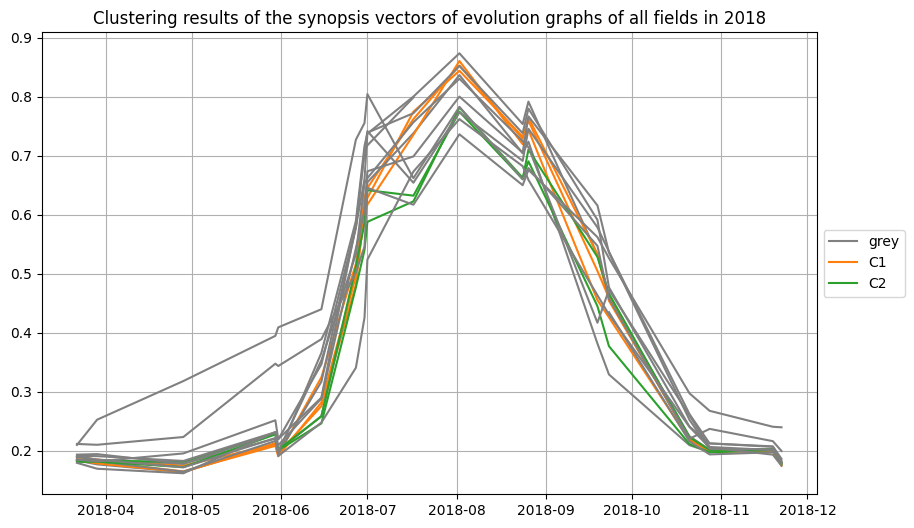

In [25]:
'''
all_synopsis_list containing the NDVI_weight_mean corressponding to the bounding box 
all_date_list containing the datae 
color --- clustering Ex (1-2-4) - (5-8) - the rest
'''
_, ax1 = plt.subplots(figsize=(10,6))
ax1.grid(True)
for i in range(len(all_synopsis_list)):
    ax1.plot(all_date_list[i], all_synopsis_list[i], color=label_color[str(i)])
legend_element = [plt.Line2D([0], [0], color=c, linestyle='-') for c in cluster_color.keys()]
legend_label = [i for i in cluster_color.keys()]
ax1.legend(legend_element, legend_label,loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
# ax1.legend(legend_element, legend_label, bbox_to_anchor=(0.75, 0.7), bbox_transform=plt.gcf().transFigure)
plt.title(f"Clustering results of the synopsis vectors of evolution graphs of all fields in {year_choice}")
plt.show()

In [26]:
def plotAnamoly(listAnomaly,all_date_list,all_synopsis_list,syn_label):    
    plt.close('all')
    fig, axs = plt.subplots(nrows= len(listAnomaly),figsize= (10,20))    
    for num,i in enumerate(listAnomaly):         
        idx = int(i)
        axs[num].plot(all_date_list[idx], all_synopsis_list[idx], color=label_color[str(idx)])        
        axs[num].set_title(f'Evolution graph synopsis of {syn_label[idx]}')
        axs[num].grid(True)
        plt.show()

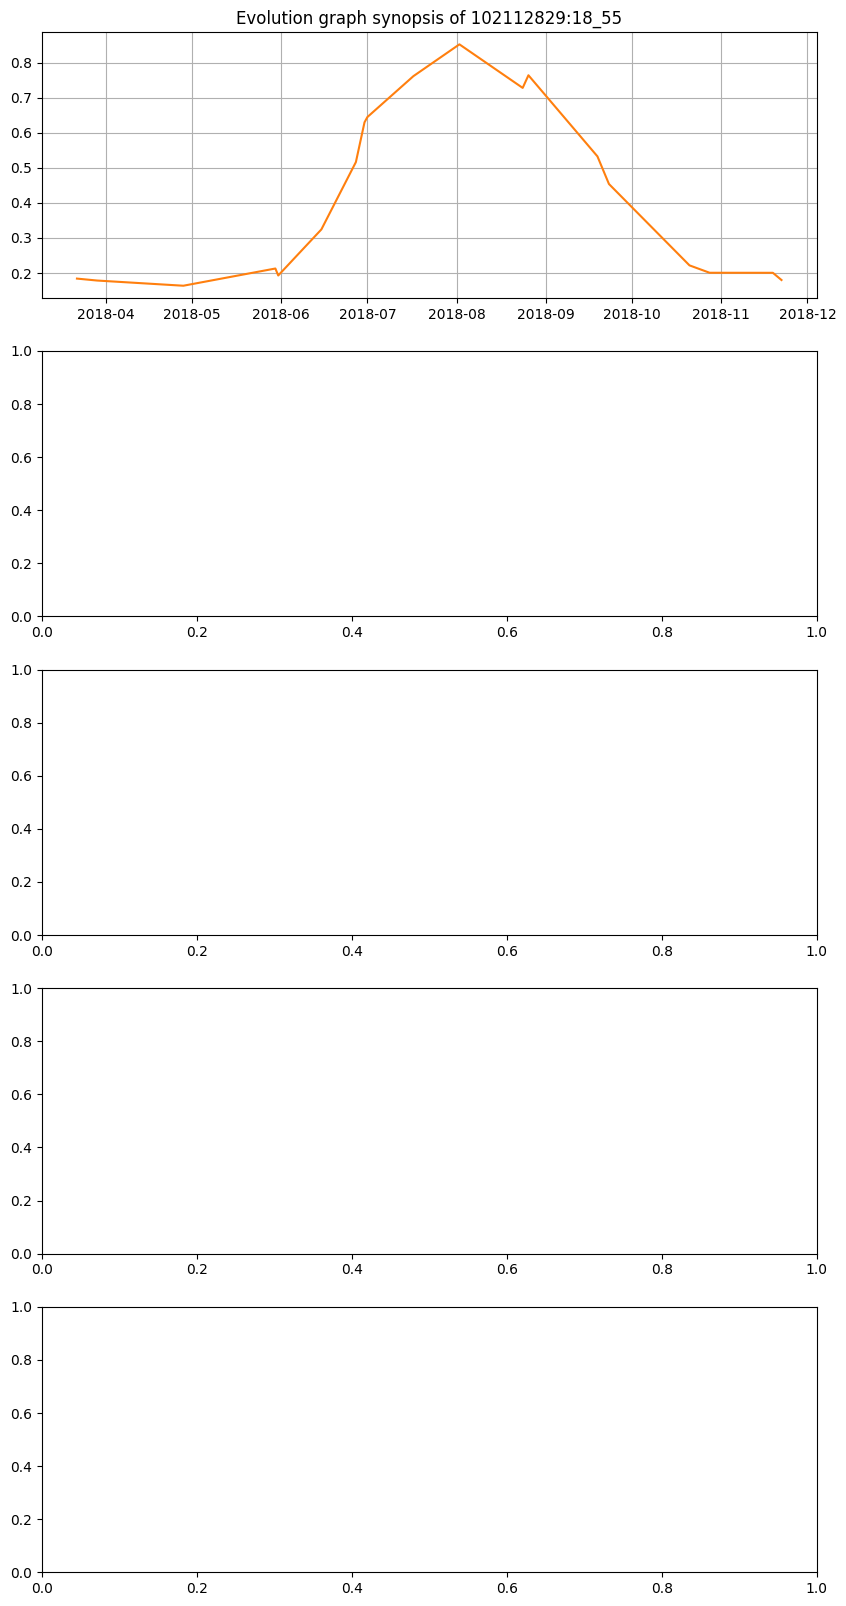

In [27]:
plotAnamoly(listAnomaly,all_date_list,all_synopsis_list,syn_label)

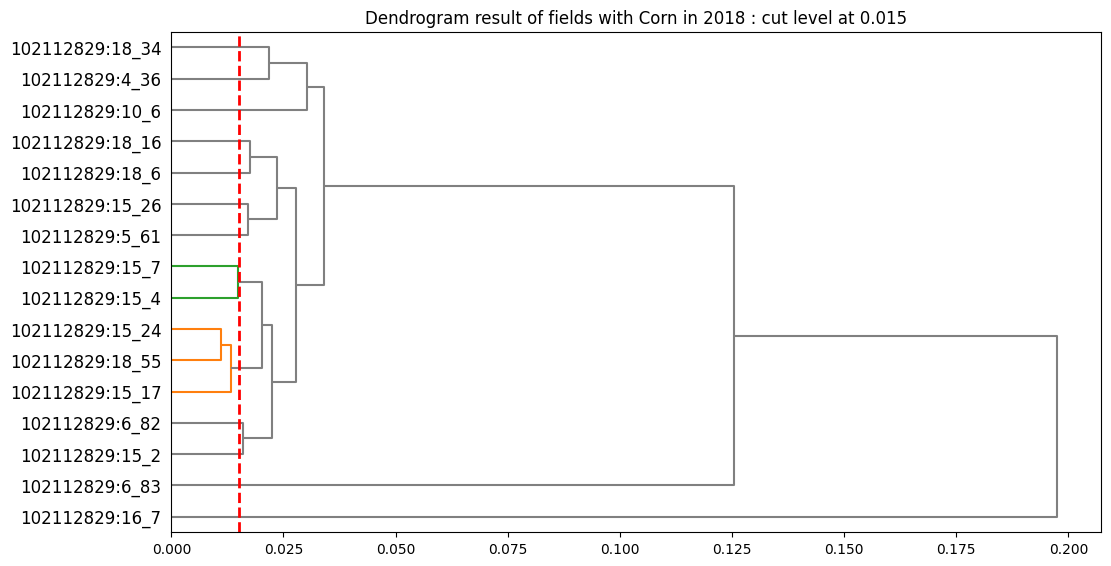

In [28]:
# dendrogram with evolution graph id
fig = plt.figure(figsize=(12, 6.5))
d_id = dendrogram(Z, orientation='right', truncate_mode='level', p=n_synopsis, labels=syn_label, color_threshold=threshold, above_threshold_color='grey')

plt.axvline(x=threshold, c='r', lw=2, linestyle='dashed')
plt.title(f"Dendrogram result of fields with {crop_type} in {year_choice} : cut level at {threshold}")
plt.show()
cluster_color_id = get_cluster_color(d_id)
label_color_id = {label:k for k,v in cluster_color_id.items() for label in v}

# Evolution of BoundingBox images

In [28]:
import cv2
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib widget

C:\Users\qle\AppData\Local\miniconda3\envs\text\Lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


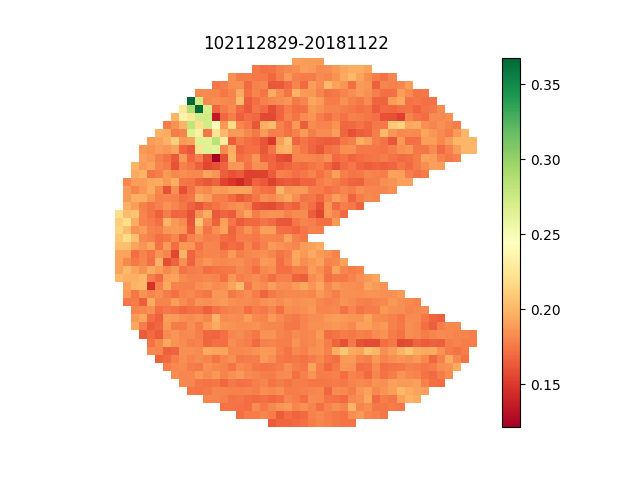

In [29]:
### Generate the img_ndvi_tif
def Generate_NDVI_Image(data_path,fileList, savePath):
    '''
    Generate the NDVI Image and save it on the specific directory
    '''
    NDVI_numpy = []
    DATE = []
    for idx,img in enumerate(fileList):
        sfd_id = img.split('_')[0]
        Date = img.split('_')[2]
        file = data_path + sfd_id +'/' + ndvi_tif_file[idx]
        ndvi_raster_band  = rasterio.open(file)
        ndvi_image = ndvi_raster_band.read(1,masked=True)
        NDVI_numpy.append(ndvi_image)
        DATE.append(Date)
        #cmap, norm = get_palette(ndvi_image)
        
        plt.close('all')
        plt.title(f'{sfd_id}-{Date}')
        plt.axis('off')
        plt.imshow(
            ndvi_image,
            cmap='RdYlGn',            
            )
        plt.colorbar()
        '''
        if not os.path.exists(f'{savePath}/NDVI/{sfd_id}/'):
            os.makedirs( f'{savePath}/NDVI/{sfd_id}/')
        plt.savefig(f'{savePath}/NDVI/{sfd_id}/{Date}.png ',format='png')        
        '''
    return NDVI_numpy, DATE, sfd_id
        
NDVI_numpy, DATE, sfd_id = Generate_NDVI_Image(data_path,ndvi_tif_file,savePath)

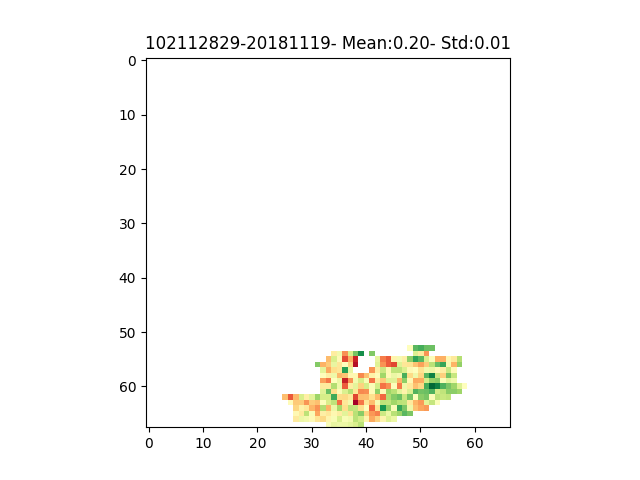

In [30]:
### Yield the clipping path and Evolution process + Synopsis of the class
def EvolutionGraphEvolution(NDVI_numy,segments_test,Position_image,bouding_box_segment,DATE,sfd_id):
    """
    Plot clipping images coresponding to the position_image and bonding_box_seggment
    """
    # Position_image= 15
    seg_image = segments_test[Position_image] # 68x67
    #bouding_box_segment = 7
    mask =np.zeros(seg_image.shape, dtype=np.uint8)
    mask[seg_image == bouding_box_segment] =1
    meanL=[]
    stdL=[]
    DateCorres= []
    for idx,test in enumerate(NDVI_numpy):        
        if test.shape != mask.shape:
            continue
        clipped_image = np.ma.masked_values(cv2.bitwise_and(test, test, mask=mask),0)
        mean = np.nanmean(clipped_image)
        std = np.nanstd(clipped_image)
        
        meanL.append(mean)
        stdL.append(std)
        DateCorres.append(DATE[idx])
        
        plt.close('all')
        plt.title(f'{sfd_id}-{DATE[idx]}- Mean:{mean:.2f}- Std:{std:.2f}')
        #plt.axis('off')
        plt.imshow(
            clipped_image,
            cmap='RdYlGn',            
            )
        """
        plt.colorbar()        
        if not os.path.exists(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}'):
            os.makedirs( f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}')
        plt.savefig(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}/{DATE[idx]}.png ',format='png')  
        """
    return meanL,stdL,DateCorres  
   
mean15_7, std15_7, DateCorres  = EvolutionGraphEvolution(NDVI_numpy, segments_test, 15, 7, DATE,sfd_id)
mean15_4, std15_4, DateCorres  = EvolutionGraphEvolution(NDVI_numpy, segments_test, 15, 4, DATE,sfd_id)
mean15_17,std15_17, DateCorres = EvolutionGraphEvolution(NDVI_numpy, segments_test, 15,17, DATE,sfd_id)
mean15_24,std15_24, DateCorres = EvolutionGraphEvolution(NDVI_numpy, segments_test, 15,24, DATE,sfd_id)
mean18_55,std18_55, DateCorres = EvolutionGraphEvolution(NDVI_numpy, segments_test, 18,55, DATE,sfd_id)


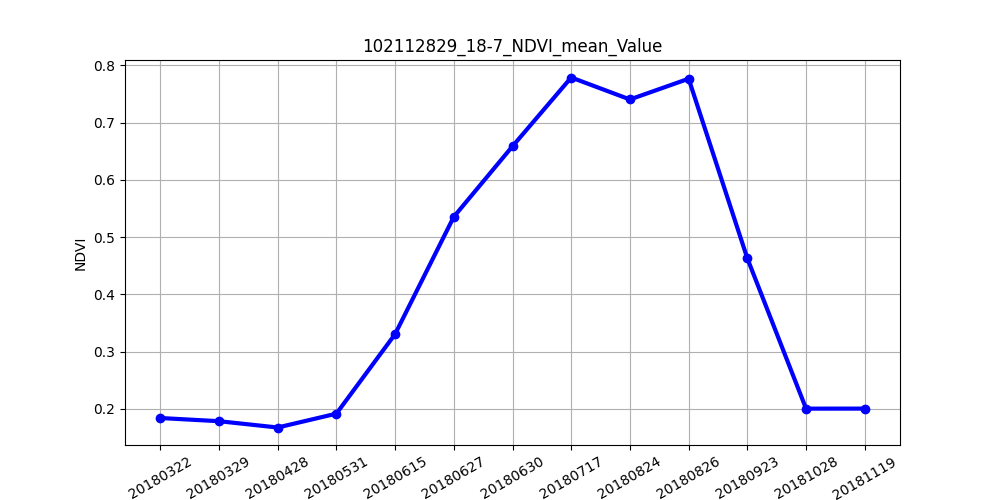

In [31]:
def PlotSypnosis(mean, std,Position_image,bouding_box_segment,DATE,sfd_id):
    
    plt.close('all')
    plt.figure(figsize=(10,5))    
    plt.plot(mean, lw=3, marker='o',c='b',)
    plt.title(f'{sfd_id}_{Position_image}-{bouding_box_segment}_NDVI_mean_Value')
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.xticks(np.arange(len(DATE)), DATE, rotation=30)
    """
    if not os.path.exists(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}'):
        os.makedirs( f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}')
    plt.savefig(f'{savePath}/EvolutionProcess/{sfd_id}/{Position_image}-{bouding_box_segment}/{Position_image}-{bouding_box_segment}_NDVI_mean_Value.png ',format='png')
    """
    #plt.show()
    
PlotSypnosis(mean15_7, std15_7, 15, 7, DateCorres, sfd_id)
PlotSypnosis(mean15_4, std15_4, 15, 4, DateCorres, sfd_id)
PlotSypnosis(mean15_17, std15_17, 15, 17, DateCorres, sfd_id)
PlotSypnosis(mean15_24, std15_24, 15, 24, DateCorres, sfd_id)
PlotSypnosis(mean18_55, std18_55, 18, 7, DateCorres, sfd_id)

plt.close('all')
plt.imshow(segments_test[5])
plt.show()# Retrieve the optical data GRB
Done but not much information from

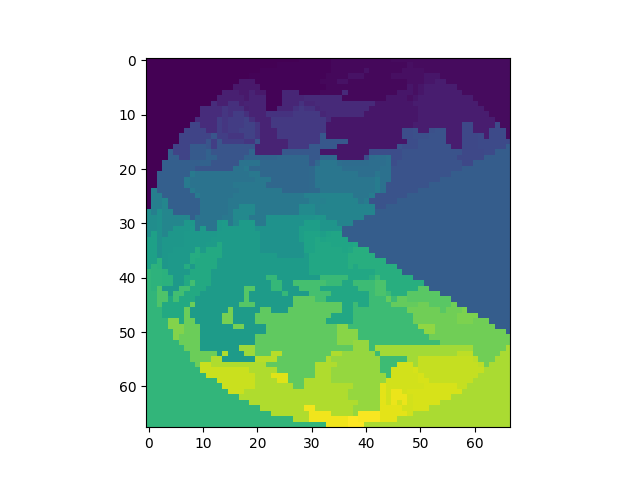

In [34]:
plt.close('all')
plt.imshow(segments_test[1])
plt.show()